In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#Reading data
df = pd.read_csv('time_series_covid_19_confirmed.csv').groupby('Country/Region').sum().iloc[:, :-3]

In [0]:
#Using data for those countries that have at least 1000 cases
df_q3 = df[df['5/27/20']>=1000]

#Computing the ratio of cases to amount of days 
difference = list()
column_len = len(df_q3.columns[2:].values.tolist())
for i in range(column_len):
  for j, index in enumerate(df_q3.index.values.tolist()):
    if len(difference) <= j:
      difference.append([[], index])
    difference[j][0].append(df_q3.loc[index, df_q3.columns[2:].values.tolist()[i]]/(i+1))

difference.sort()

In [0]:
#Finding difference between ratios of different countries as compared to Pakistan
abs_diff = list()
for i, index in enumerate(difference):
  for j in range(len(index[0])):
    if len(abs_diff) <= i:
      abs_diff.append([0, index[1]])
    abs_diff[i][0] += abs(difference[74][0][j]-index[0][j])
abs_diff.sort()
abs_diff[1:10]

[[1721.9454950712793, 'Chile'],
 [2262.0306862289153, 'Mexico'],
 [2838.6314476331977, 'Qatar'],
 [3202.0318680393098, 'Ecuador'],
 [3395.7803689645557, 'Singapore'],
 [3517.195651730621, 'Saudi Arabia'],
 [3528.2307704979007, 'Belarus'],
 [4351.3766380793295, 'Sweden'],
 [4368.098669863031, 'United Arab Emirates']]

In [0]:
#Using countries that match the best
trend_countries = df[(df.index=='Saudi Arabia')|(df.index=='Belarus')|(df.index=='Chile')|(df.index=='Qatar')|(df.index=='Pakistan')|(df.index=='Mexico')]

Text(0.5, 1.0, 'Countries with trends similar to Pakistan - COVID-19')

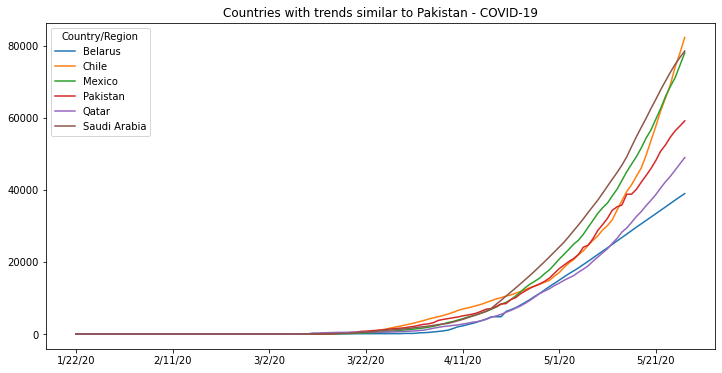

In [0]:
#Verifying trend through graph
trend_countries.iloc[:, 2:].T.plot(figsize=(12,6))
plt.title("Countries with trends similar to Pakistan - COVID-19")

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from dateutil import parser
import datetime
import warnings

In [0]:
#Making a list of all dates for the moving window
datelist = list()
date = parser.parse("05/10/20")
datelist.append(date.strftime("%m/%d/%Y"))
for i in range (48):
  date += datetime.timedelta(days=1)
  datelist.append(date.strftime("%m/%d/%Y"))

In [0]:
#Retrieving data for similar countries by trendm of COVID19
pak_series = df_q3[df_q3.index=='Pakistan'].iloc[:,2:].T.squeeze()
belarus_series = df_q3[df_q3.index=='Belarus'].iloc[:,2:].T.squeeze()
chile_series = df_q3[df_q3.index=='Chile'].iloc[:,2:].T.squeeze()
mexico_series = df_q3[df_q3.index=='Mexico'].iloc[:,2:].T.squeeze()
qatar_series = df_q3[df_q3.index=='Qatar'].iloc[:,2:].T.squeeze()
saudi_series = df_q3[df_q3.index=='Saudi Arabia'].iloc[:,2:].T.squeeze()

In [0]:
#Making Arima model
def arima_predictor(series):
  X = series.values
  train, test = X[0:109], X[109:len(X)] #values uptill 10 May will be used to train
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)+31):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    if (t < len(test)):
      obs = test[t]
    else:
      obs = yhat
    history.append(obs)
  return predictions

In [0]:
warnings.filterwarnings("ignore")
#Making models for each country 
pred_belarus = arima_predictor(belarus_series)
pred_chile = arima_predictor(chile_series)
pred_mexico = arima_predictor(mexico_series)
pred_qatar = arima_predictor(qatar_series)
pred_saudi = arima_predictor(saudi_series)
pred_pakistan = arima_predictor(pak_series)

In [0]:
#Making a dataframe of all models predictions
df_new = pd.DataFrame(list(zip(pred_belarus, pred_chile, pred_mexico, pred_qatar, pred_saudi, pred_pakistan))).T
df_new.index = ['Belarus', 'Chile', 'Mexico', 'Qatar', 'Saudi Arabia', 'Pakistan']
df_new.columns = datelist

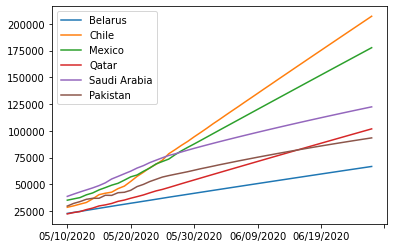

In [0]:
df_new.T.plot()

We can see that Saudi Arabia is in fact the most similar country to Pakistan w.r.t trend of COVID-19 spread but is ahead by about 20 days. So it's model will be useful in predicting the cases in pakistan.  

In [0]:
#Combining original and predicted series into a single dataframe
df_compar2 = pd.DataFrame(data=pred_pakistan).T
df_compar2.columns = datelist
df_compar1 = df[df.index=='Pakistan'].iloc[:, 2:]
df_compar1.columns = df_compar1.columns[:-18].values.tolist() + datelist[:18]
frames = [df_compar1, df_compar2]

In [0]:
result = pd.concat(frames)
result.index = ['Original Series', 'Predicted Series']

Text(0.5, 1.0, 'Model Predictor COVID-19 Pakistan')

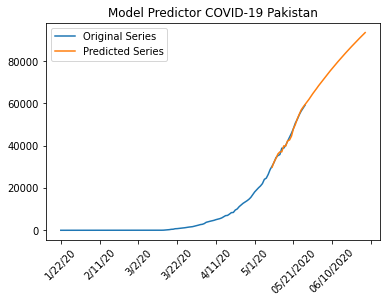

In [0]:
#Plotting the original and predicted values
result.T.plot()
plt.xticks(rotation=45)
plt.title("Model Predictor COVID-19 Pakistan")

Text(0.5, 1.0, 'Model Predictor COVID-19 Pakistan(enhanced window)')

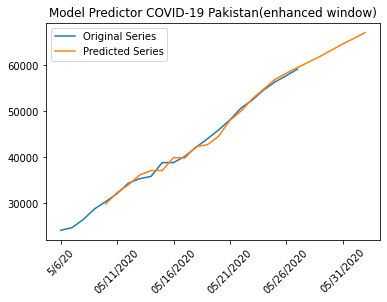

In [0]:
result.iloc[:,105:-25].T.plot()
plt.xticks(rotation=45)
plt.title("Model Predictor COVID-19 Pakistan(enhanced window)")

In [0]:
from sklearn.metrics import r2_score

In [0]:
#Evaluating model performance through r2 Score
test_values = pak_series[109:].values.tolist()
preds = pred_pakistan[:18]

error = r2_score(test_values, preds)

In [0]:
print("The confidence for predicting unknown values by our model is", error)

The confidence for predicting unknown values by our model is 0.9918882475536144
